In [23]:
# 1 定义训练参数
target = 'Close'  # 目标数据
input_len = 30  # 输入长度
output_len = 7  # 输出长度
val_rate = 0.2  # 验证集比例
test_rate = 0.1  # 测试集比例
max_epochs = 50  # 最大训练轮数
batch_size = 16  # 批量大小
hidden_size = 256  # 隐藏层神经元数
num_layers = 2  # 网络层数
learn_rate = 1e-3  # 学习率
gamma = 0.1  # 学习率调整参数
num_workers = 0  # 数据加载器线程数

In [24]:
# 2 定义模型
from LSTM_models import LSTM, CNN_LSTM, Seq2Seq

In [25]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
# 3 定义函数
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)


def bar(i, t, start, des, train=True, loss=0):
    l = 50
    f_p = i / t
    n_p = (t - i) / t
    finsh = "▓" * int(f_p * l)
    need_do = "-" * int(n_p * l)
    progress = f_p * 100
    dur = time.perf_counter() - start
    if train:
        proc = "\r{}({}/{}轮):{:^3.2f}%[{}->{}] 用时:{:.2f}s 验证集上损失:{:.3f} ".format(des, i, t,
                                                                                          progress,
                                                                                          finsh,
                                                                                          need_do, dur,
                                                                                          loss)
    else:
        proc = "\r{}:{:^3.2f}%[{}->{}] 用时:{:.2f}s".format(des, progress, finsh, need_do, dur)
    print(proc, end="")


def val_plot(m_epoch, loss_list, title):
    min_val_loss = min(loss_list)
    epochs = len(loss_list)
    figure(figsize=(10, 8))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(loss_list, color='red', label='LOSS')
    plt.scatter(m_epoch, min_val_loss, color='blue', s=80)
    plt.scatter(0.68 * epochs, 0.95 * max(loss_list), color='blue', s=80)
    min_val_loss = '%.6f' % min_val_loss
    text = f'min loss:{min_val_loss}'
    plt.text(0.70 * epochs, 0.95 * max(loss_list), text, ha='left', va='center', size=20)
    plt.title(title, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim((0, max(loss_list)))
    plt.show()


def compare_plot(title, y_pre, y_real):
    figure(figsize=(10, 8))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(y_pre, color='blue', label='predict')
    plt.plot(y_real, color='red', label='real')
    plt.title(f'{title}', fontsize=20)
    plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 30, 'fontsize', 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()


def te_plot(title, lstm_model, test_num, Dte, data, device, pred_size, interval, scaler):
    ts = test_num + interval  # 预测的起始位置
    te = test_num + interval + pred_size + len(Dte) - 1  # 预测的结束位置
    y_pred_list = np.zeros((len(Dte), len(Dte) + pred_size - 1), dtype=float)  # 预测滑动预测结果全维度矩阵
    count = 0  # 对预测到第几个数据进行计数
    lstm_model.eval()
    for seq, _ in Dte:
        seq = seq.to(device)
        with torch.no_grad():  # 预测时不需要反向传播优化权重，防止权重修改
            y_pred = lstm_model(seq)[0]  # 预测结果，由于batch为1,所以取第一个
            y_pred = y_pred.cpu().detach().numpy()  # 将预测结果放到cpu上，取出数据并转为numpy数组
            y_pred_list[count, count:count + len(y_pred)] = y_pred  # 将预测结果放到全维度矩阵的对应位置上
            # y_pred_list += y_pred.tolist()
        count += 1
    # 根据全维度矩阵对同一时刻的多个预测结果进行加权求和
    y_re = []
    for i in range(len(Dte) + pred_size - 1):
        col = y_pred_list[:, i]  # 取出同一时刻的预测列
        not_zero = np.where(col != 0)  # 找出预测列中的非零数据，代表同一时刻的所有预测结果
        r_col = col[not_zero]
        # 按照相对距离计算权重
        dis = np.arange(len(r_col)) + 1  #由预测列预测结果个数反应它们与输入之间的相对距离
        dis = dis / sum(dis)  #归一化相对距离
        va = sum(r_col * dis)  #加权求和
        y_re.append(va)

    y_re = np.array(y_re).reshape(-1, 1)  #转换为numpy数组，并reshape为列向量才能用标准化器反标准化
    y_re = scaler.inverse_transform(y_re).flatten()  #反标准化，将预测结果展平回一维
    y_real = data[ts:te]  #获取预测数据对应时间段的真实数据
    compare_plot(f'{title}-test', y_re, y_real)  #绘制预测结果与真实数据对比图
    return y_re, y_real


def calculate_err(y_re, y_real):
    MSE = np.sum((y_re - y_real) ** 2) / len(y_real)
    RMSE = np.sqrt(MSE)
    MAE = np.sum(np.abs(y_re - y_real)) / len(y_real)
    MAPE = np.sum(np.abs((y_re - y_real) / y_real)) / len(y_real) * 100
    S = np.abs(y_re - y_real) / ((np.abs(y_re) + np.abs(y_real)) / 2)
    SMAPE = np.sum(S) / len(y_real) * 100
    av_y = sum(y_real) / len(y_real)
    R2 = 1 - np.sum((y_re - y_real) ** 2) / np.sum((av_y - y_real) ** 2)
    return MSE, RMSE, MAE, MAPE, SMAPE, R2


def ini_env():
    import torch
    if torch.cuda.is_available():
        gpu_num = torch.cuda.device_count()
        device = torch.device('cuda')
        gpus = [i for i in range(gpu_num)]
        torch.cuda.set_device('cuda:{}'.format(gpus[0]))
    else:
        device = torch.device('cpu')
        gpus = []
    return device, gpus


def select_model(model_name, input_size, hidden_size, num_layers, output_len, batch_size, device):
    if model_name == 'LSTM':
        layer_mat = [input_size, 128]
        model = LSTM(layer_mat, hidden_size, num_layers, output_len, batch_size, device)
    elif model_name == 'CNN_LSTM':
        model = CNN_LSTM(input_size, hidden_size, num_layers, output_len, batch_size, device)
    elif model_name == 'Seq2Seq':
        model = Seq2Seq(input_size, hidden_size, num_layers, output_len, batch_size, device)
    else:
        raise ValueError('model name error')
    return model


def process(data, batch_size, shuffle, num_workers, input_len, output_len, output_col):
    data = data.tolist()  # 转换为列表，列表用FloatTensor转换为tensor更快，且可以保证32位(Float为32位，Double位为64位)
    #直接对numpy转换需要用from_numpy,且位数和原np数组一致，无法指定
    dataset = []
    # 滑动生成数据集
    for i in range(len(data) - input_len - output_len):
        seq = []
        label = []
        # 数据为二维，第一维是时间，长度是输入步长，第二维是各种特征数
        for j in range(i, i + input_len):
            x = data[j]
            seq.append(x)
        # 标签从数据的最后一步继续，第一维是时间长度是输出步长，第二维是目标特征数，根据前面得到的目标列索引获取
        for j in range(i + input_len, i + input_len + output_len):
            x = data[j][output_col]
            label.append(x)
        # 转换为张量Tensor
        train_seq = torch.FloatTensor(seq)
        # train_label = torch.FloatTensor(train_label).view(-1)

        train_label = torch.FloatTensor(label)
        # print(train_seq.shape, train_label.shape)
        # 构建数据-标签对
        dataset.append((train_seq, train_label))

    # 根据数据-标签对构建数据集
    dataset = MyDataset(dataset)
    # 根据数据集构建数据加载器，batch是压缩量，shuffle表示是否打乱数据，num_workers是加载数据的线程数，drop_last为是否舍弃最后不足一个batch的数据

    Dseq = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
                      drop_last=False)
    return Dseq



Making dataset...
Done!
LSTM training...
训练进度(50/50轮):100.00%[▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓->] 用时:31.30s 验证集上损失:0.052 


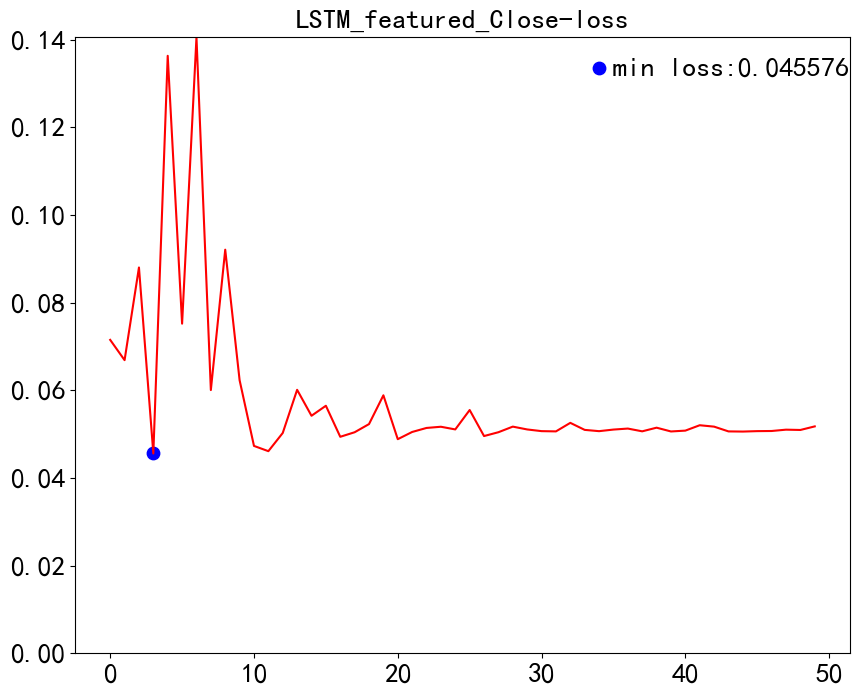

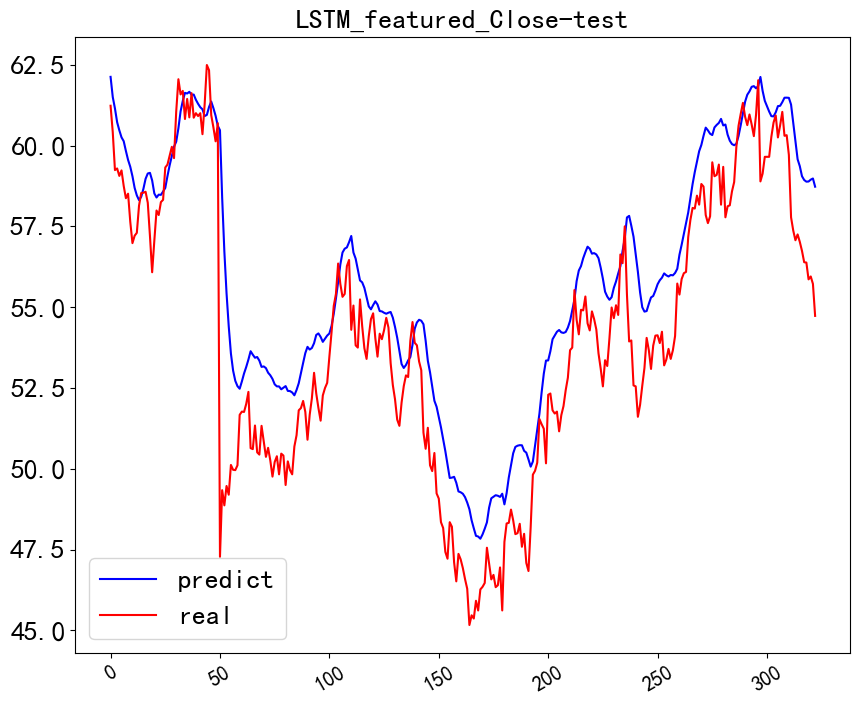

MSE:4.874471476866215
RMSE:2.2078205264165414
MAE:1.7681138642642147
MAPE:3.3827869822992933
SMAPE:3.293687218185002
R2:0.7465514554972021
Making dataset...
Done!
CNN_LSTM training...
训练进度(50/50轮):100.00%[▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓->] 用时:29.49s 验证集上损失:0.053 


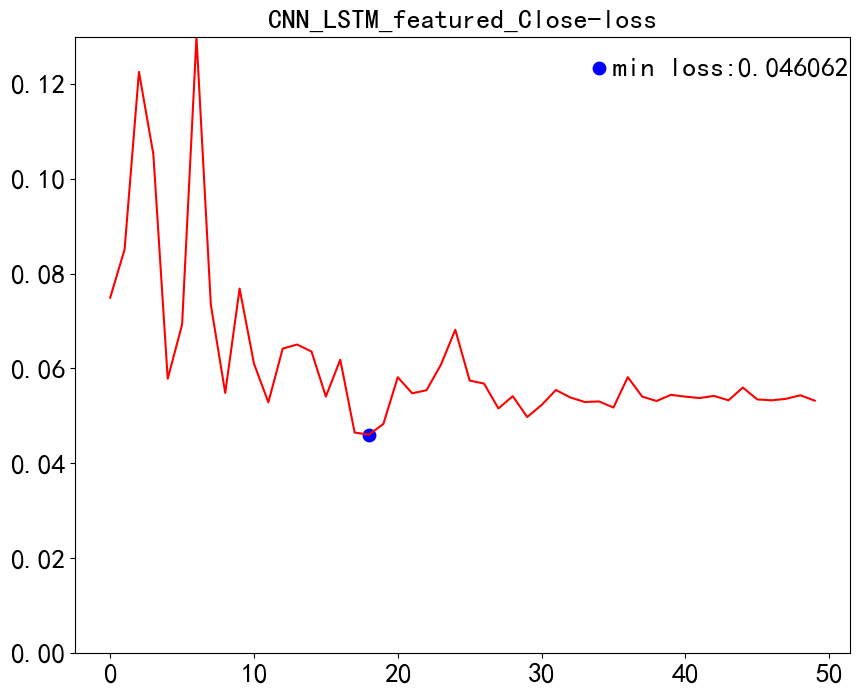

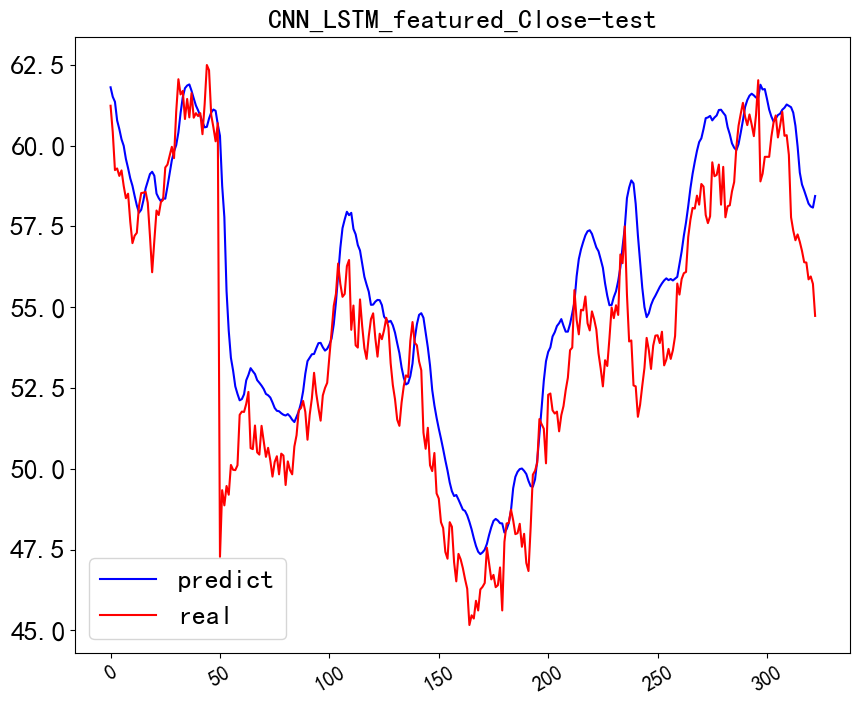

MSE:4.7999787441446164
RMSE:2.1908853790521805
MAE:1.6784277203247044
MAPE:3.1852401973572544
SMAPE:3.100377177328648
R2:0.7504247112489135
Making dataset...
Done!
Seq2Seq training...
训练进度(50/50轮):100.00%[▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓->] 用时:63.94s 验证集上损失:0.051 


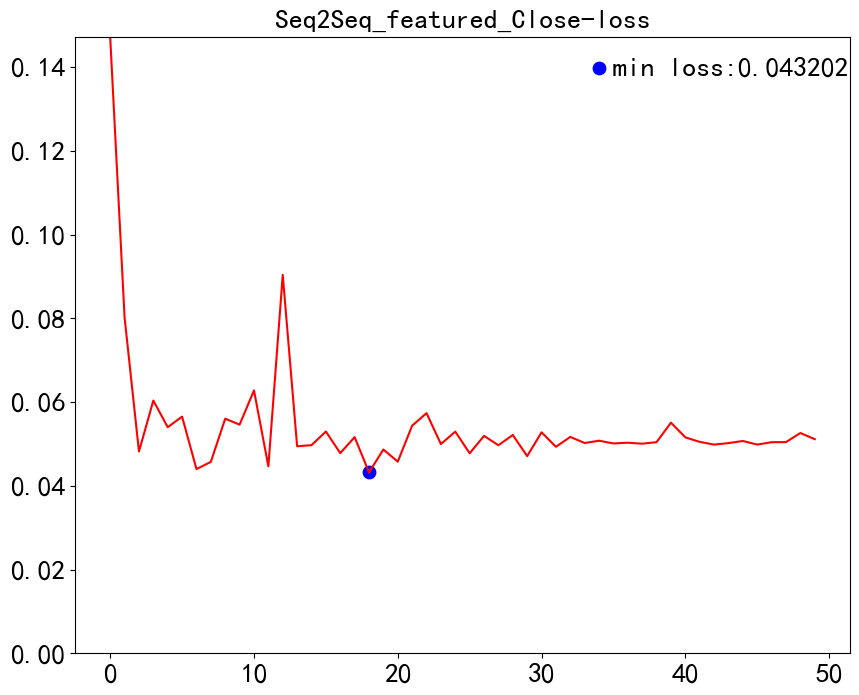

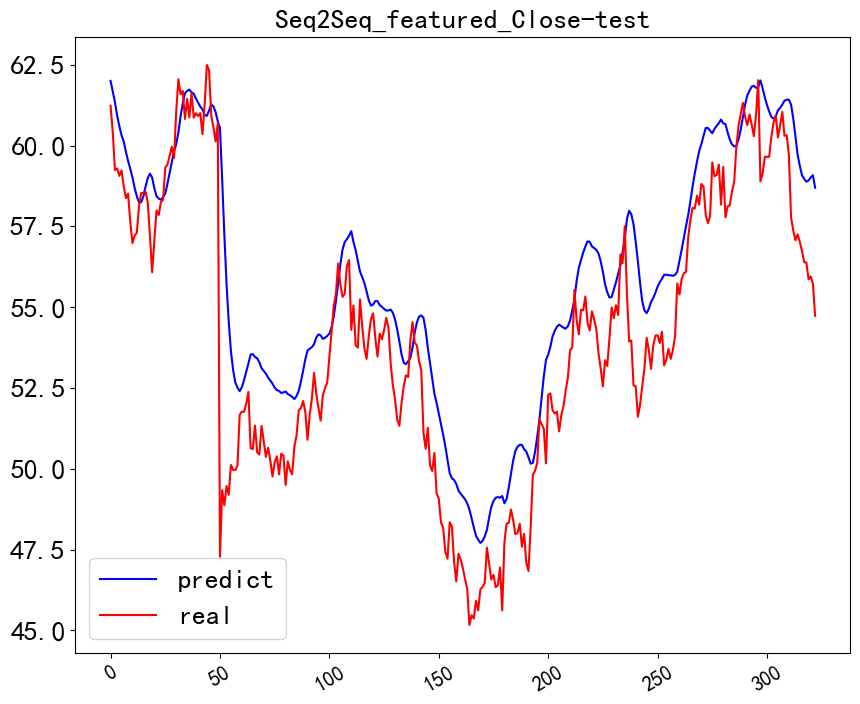

MSE:5.090700554060754
RMSE:2.256258086757974
MAE:1.7929909745316714
MAPE:3.426694978623515
SMAPE:3.3342245254977603
R2:0.7353086068818746


In [26]:
# 3 加载数据、训练、测试
import time
import pandas as pd
import numpy as np
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Scaler


def train(is_init, model_name, num_workers):
    if is_init:
        data = pd.read_csv('./tmp/cleaned_stock_prices.csv')  # is_init时读取原始进行训练
        r_name = model_name + '_init_' + target  # 定义输出到命令行和表中的标签
    else:
        data = pd.read_csv('./tmp/final_data.csv')  # 不是is_init时读取经过特征提取的数据进行训练
        r_name = model_name + '_featured_' + target
    Date = data['Date']
    data = data.drop(['Date'], axis=1)  # 删除日期列
    columns = data.columns  # 获取列名
    np_data = data.values.astype(np.float32)  # 获取数据值并转换为numpy32位数组(pytorch的神经网络中间参数默认为32位，需对应)
    target_col = np.where(columns == target)[0][0]  # 获取目标列的索引

    val_num = np_data.shape[0] - int(np_data.shape[0] * (val_rate + test_rate))  # 计算验证集的数量
    test_num = np_data.shape[0] - int(np_data.shape[0] * test_rate)  # 计算测试集的数量

    train_data = np_data[:val_num]  # 划分训练集、验证集、测试集
    val_data = np_data[val_num:test_num]
    test_data = np_data[test_num:]
    target_data = np_data[:, target_col]  # 获取目标列数据
    scaler = Scaler()  # 初始化标准化器

    # 对训练数据进行标准化，并按照训练数据的标准化器对验证集和测试集进行标准化
    train_scale = scaler.fit_transform(train_data)
    val_scale = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)
    # 获取目标列的标准化器用作预测时的反标准化
    label_scaler = Scaler()
    label_scaler.fit_transform(train_data[:, target_col:target_col + 1])
    # 输出数据的形状
    # print(train_scale.shape)
    # print(val_scale.shape)
    # print(test_scaled.shape)
    print(f'Making dataset...')  #构建数据集
    Dtr = process(train_scale, batch_size, True, num_workers, input_len, output_len, target_col)
    DVa = process(val_scale, batch_size, True, num_workers, input_len, output_len, target_col)
    #测试集不打乱，不需要batch，只需要按照时间顺序取出数据，方便按顺序预测
    Dte = process(test_scaled, 1, False, num_workers, input_len, output_len, target_col)
    print('Done!')
    device, gpus = ini_env()  # 初始化计算环境
    model = select_model(model_name, np_data.shape[1], hidden_size, num_layers, output_len, batch_size,
                         device)  # 选择并生成模型
    model = model.to(device)  # 将模型放到计算平台上
    optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate)  # 选择优化器
    # 学习率调整策略，5轮没有优化就降低学习率为原来的0.1
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    # 均方误差MSE作为损失函数
    loss_fn = nn.MSELoss()

    min_val_loss = np.Inf
    loss_list = []

    print(f'{model_name} training...')
    start_time = time.perf_counter()
    for epoch in range(max_epochs):  # 训练max_epochs轮
        model.train()  # 训练模式
        for (seq, label) in Dtr:  # 逐个取出训练数据和对应的标签
            seq = seq.to(device)  # 将数据放到计算平台上
            label = label.to(device)  # 将标签放到计算平台上
            y_pred = model(seq)  # 计算模型输出
            # print(label.shape, y_pred.shape)
            loss = loss_fn(y_pred, label)  # 计算模型输出与标签之间的损失
            optimizer.zero_grad()  # 梯度清零
            loss.backward()  # 反向传播
            optimizer.step()  # 用优化器优化权重
        model.eval()  # 验证模式
        total_val_loss = 0  # 记录验证集上的损失
        with torch.no_grad():  # 验证数据集时禁止反向传播优化权重
            for seq, label in DVa:  # 逐个取出验证数据和对应的标签
                seq = seq.to(device)
                label = label.to(device)
                outputs = model(seq)
                loss = loss_fn(outputs, label)
                total_val_loss = total_val_loss + loss.item()  # 计算验证集上的损失的和（和的数值大一些，容易打印）
        loss_list.append(total_val_loss)
        scheduler.step(total_val_loss)  # 根据验证集上的总损失作为调整学习率的参数
        if total_val_loss < min_val_loss:  # 记录最小的验证集上的损失
            min_val_loss = total_val_loss
            m_epoch = epoch  # 记录最小损失的轮数
        bar(epoch + 1, max_epochs, start_time, '训练进度', train=True, loss=total_val_loss)  # 打印训练进度

    print()
    val_plot(m_epoch, loss_list, f'{r_name}-loss')  # 绘制验证集上的损失曲线
    y_re, y_real = te_plot(r_name, model, test_num, Dte, target_data, device, output_len, input_len,
                           label_scaler)  # 绘制测试集上的预测结果

    MSE, RMSE, MAE, MAPE, SMAPE, R2 = calculate_err(y_re, y_real)  # 计算预测结果的误差
    print(f'MSE:{MSE}\nRMSE:{RMSE}\nMAE:{MAE}\nMAPE:{MAPE}\nSMAPE:{SMAPE}\nR2:{R2}')


for model_name in ['LSTM', 'CNN_LSTM', 'Seq2Seq']:  # 在特征提取后的数据上逐个训练模型，分别为LSTM、CNN_LSTM、Seq2Seq
    train(False, model_name, num_workers)


In [27]:
# 4 对未提取的数据进行训绽

Making dataset...
Done!
LSTM training...
训练进度(50/50轮):100.00%[▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓->] 用时:30.79s 验证集上损失:0.060 


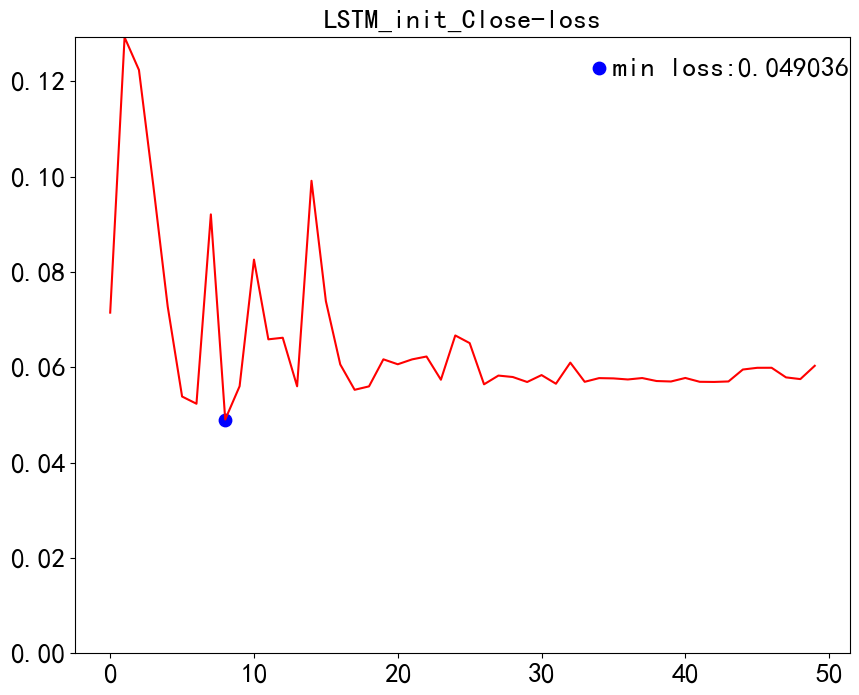

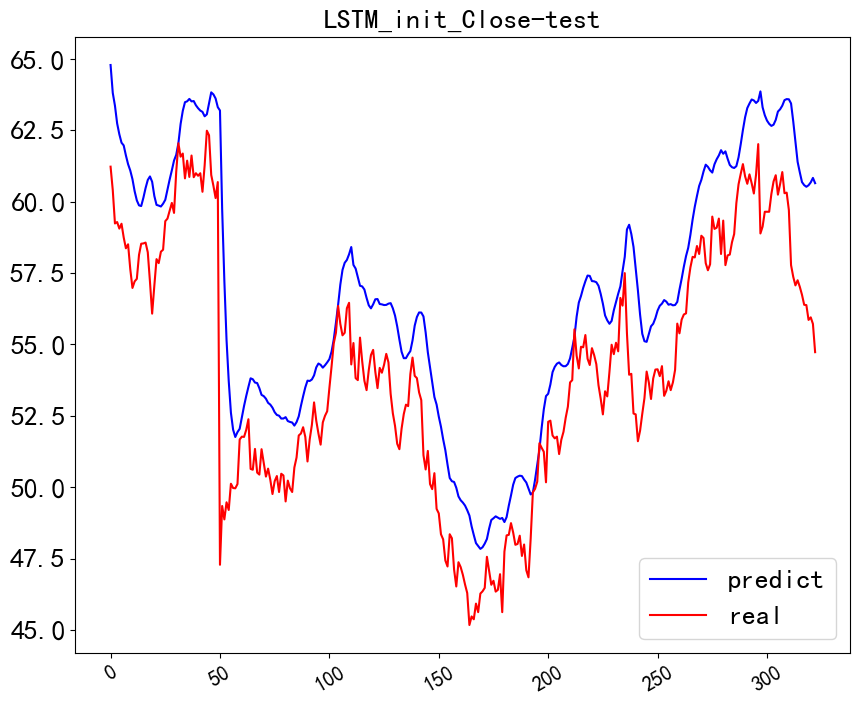

MSE:8.514976228991872
RMSE:2.9180432191782
MAE:2.5175042346887713
MAPE:4.699487449056768
SMAPE:4.553363032121766
R2:0.557263112122803
Making dataset...
Done!
CNN_LSTM training...
训练进度(50/50轮):100.00%[▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓->] 用时:28.36s 验证集上损失:0.059 


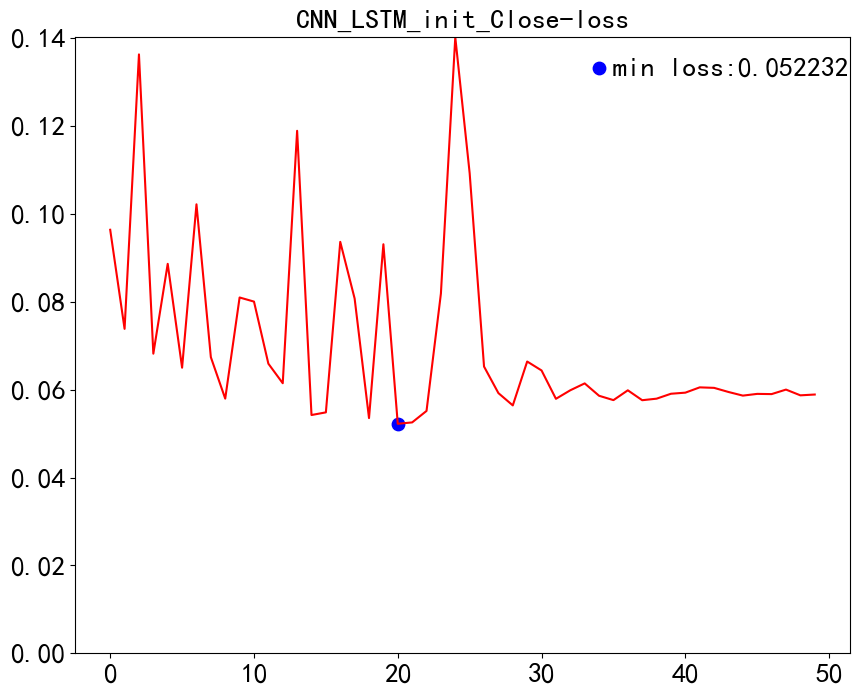

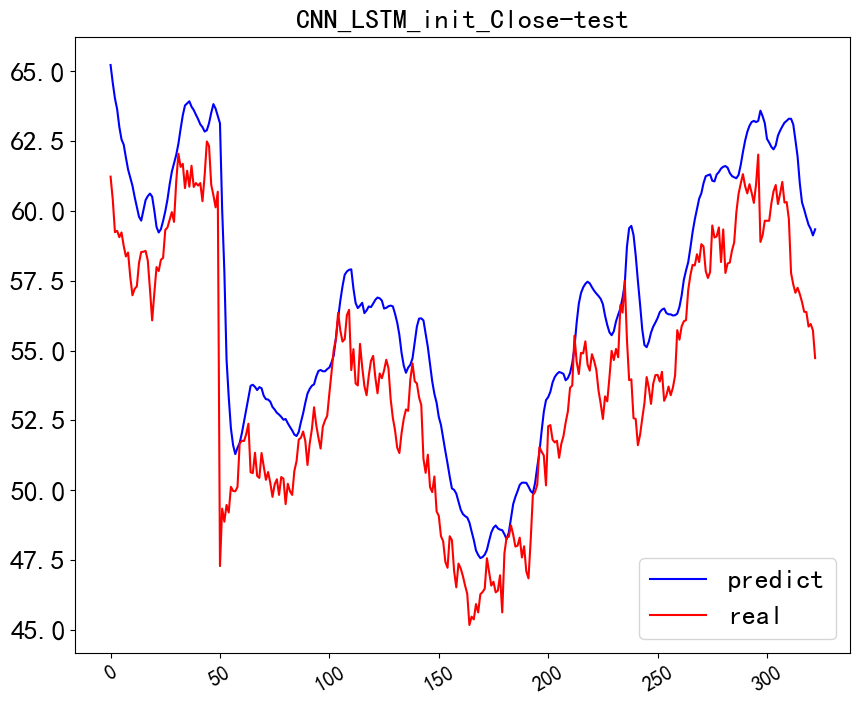

MSE:8.360406869593447
RMSE:2.891436817499813
MAE:2.434244077290943
MAPE:4.543620863528227
SMAPE:4.400115715154183
R2:0.5652999586507155
Making dataset...
Done!
Seq2Seq training...
训练进度(50/50轮):100.00%[▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓->] 用时:65.20s 验证集上损失:0.055 


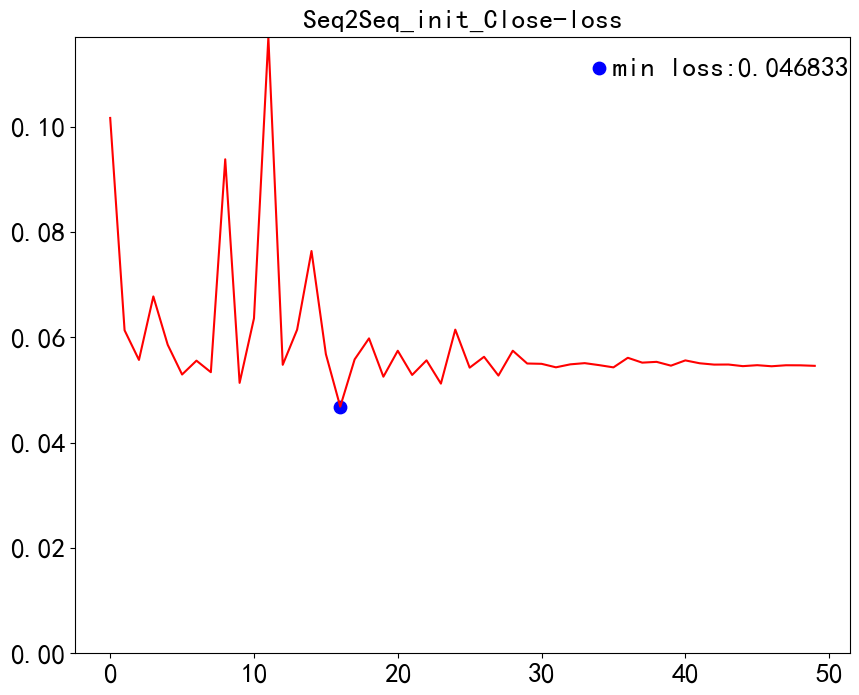

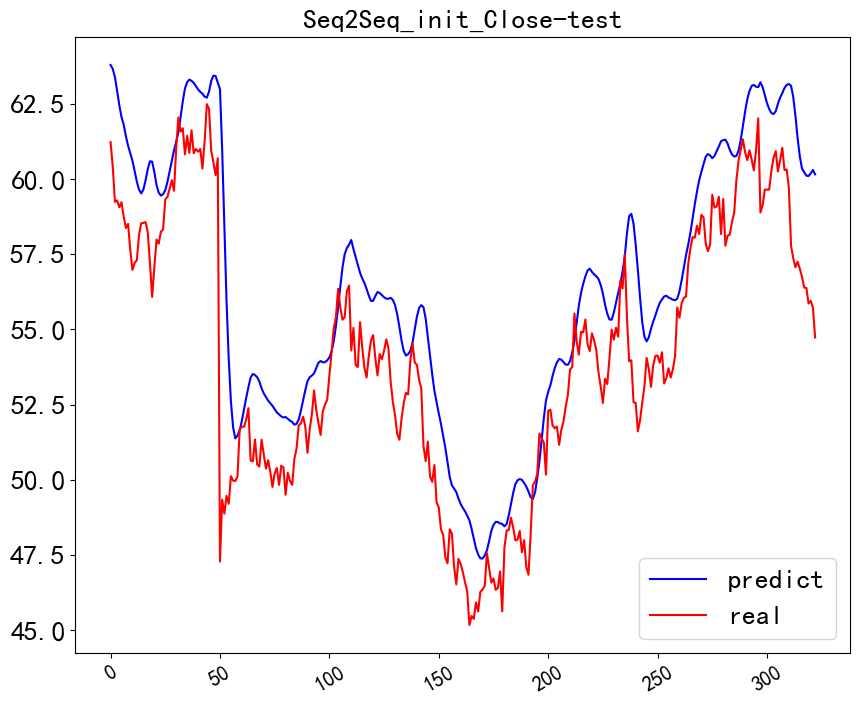

MSE:7.2036292533119735
RMSE:2.68395775922647
MAE:2.1685536738069944
MAPE:4.057122660819525
SMAPE:3.932785988802053
R2:0.6254467057496322


In [28]:
for model_name in ['LSTM', 'CNN_LSTM', 'Seq2Seq']:  # 在未提取的原数据上逐个训练模型，分别为LSTM、CNN_LSTM、Seq2Seq
    train(True, model_name, num_workers)